# Set-Up

After the activation of the Databricks Service and Cluster, import or create a new Notebook and associate it to the Cluster.

In this case the Data Source is a SQL Database on Azure.

In [ ]:
import mlflow
import mlflow.keras
import mlflow.tensorflow
from azure.storage.blob     import BlobServiceClient
from pyspark.sql.functions  import col, pandas_udf, struct
!pip install databricks-cli

In [ ]:
#Create a ML Flow experiment and associate it to the notebook
mlflow.set_experiment("/EXP-XXX-PRD")

In [ ]:
Sample_To_Extract = dbutils.widgets.get("# Records to Extract")
_Db = dbutils.widgets.get("Select Database Name")

In [ ]:
# Set the parameters to use in order to connect to the choosen database
jdbcHostname = "db-XXX-prd.database.windows.net"
jdbcDatabase = _Db
jdbcPort = 1234
username = "xxx_xxx"
password = "***"

##In case you create a secret for storing username or password (suggested option) use the code below
#username = dbutils.secrets.get(scope = "jdbc", key = "username")
#password = dbutils.secrets.get(scope = "jdbc", key = "password")

In [ ]:
# Create the JdBUrL Input Structure
jdbcUrl = "jdbc:sqlserver://{0}:{1};database={2}".format(
    jdbcHostname, jdbcPort, jdbcDatabase
)
connectionProperties = {
    "user": username,
    "password": password,
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver",
}

In [ ]:
# Execute the following code to perform the SQL connection and the query extraction to a df format
pushdown_query = (
    "(select top "
    + str(Sample_To_Extract)
    + " \
IIF(a.DescArticolo = '@',a.DescCodiceEan, a.DescArticolo) as 'DescArticolo',\
Nodo1_ID,Nodo2_ID,Nodo3_ID,Nodo4_ID from DIM_CATEGORY_ECR_MAPPING a ) query "
)
df = spark.read.jdbc(url=jdbcUrl, table=pushdown_query, properties=connectionProperties)
display(df)
df_1 = df.toPandas()

# Model with ML Flow

Here there is an example of a Random Forest Model with the parameters tracking on ML Flow Experiment.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import classification_report, confusion_matrix, accuracy_score

#ML Flow autolog setting
#Enable autolog()
#mlflow.sklearn.autolog() requires mlflow 1.11.0 or above.
mlflow.sklearn.autolog()
with mlflow.start_run():
    #Set the model parameters 
    n_estimators        = 200
    max_depth           = 60
    min_samples_split   = 2
    min_samples_leaf    = 2
    bootstrap           = False
    warm_start          = True
    verbose             = 1
    max_features        = 'sqrt'
    clf                 = RandomForestClassifier(n_estimators=n_estimators,
    random_state        = 1337,
    min_impurity_split  = True,
    max_depth           = max_depth,
    min_samples_split   = min_samples_split,
    min_samples_leaf    = min_samples_leaf,
    bootstrap           = bootstrap,
    warm_start          = warm_start,
    verbose             = verbose,
    max_features        = max_features
    )
    clf.fit(train_X, train_Y)
    %time _predictions  = clf.predict(test_X)
    %time _probas       = clf.predict_proba(test_X)

    _dd = {
        _i: _y
        for (_i, _y) in sorted(
            [(label, int(_L.transform([label]))) for label in _L.classes_]
        )
    }
    _dd1 = take(_probas.shape[1], _dd)

    predictions = pd.Series(data=_predictions, index=test_X.index, name="predicted_value")

    cols = [
        u"probability_of_value_%s" % label
        for (_, label) in sorted([(int(_dd[label]), label) for label in _dd1])
    ]

    probabilities = pd.DataFrame(data=_probas, index=test_X.index, columns=cols)
    acc = accuracy_score(test_Y, _predictions)

    #The Parameter monitored is the Accuracy
    mlflow.log_metric("Test Accuracy", acc)
    mlflow.end_run()

Here and Example of the executions tracking from Databricks ML Flow Experiment

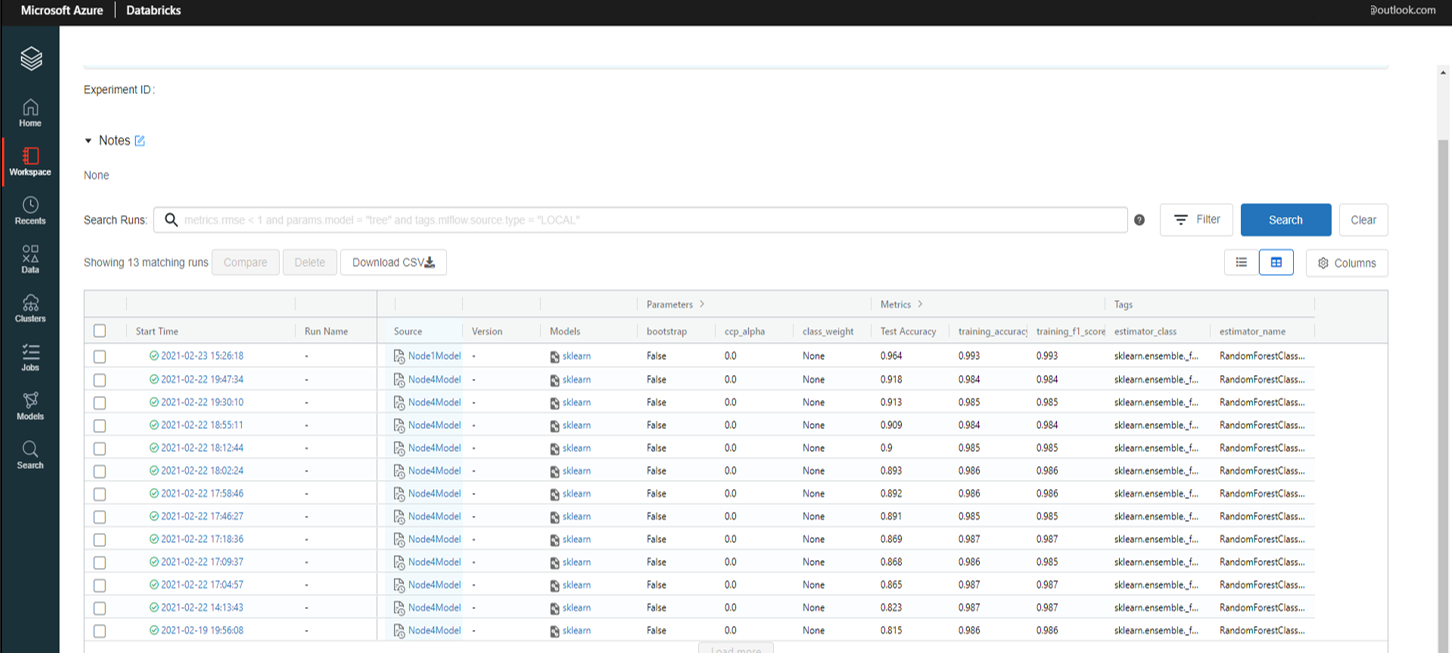

# Learning Path Microsoft

Here a link for the Microsoft Free online courses:

[https://docs.microsoft.com/it-it/learn/browse/](https://docs.microsoft.com/it-it/learn/browse/)

[https://docs.microsoft.com/it-it/learn/paths/perform-data-science-azure-databricks/](https://docs.microsoft.com/it-it/learn/paths/perform-data-science-azure-databricks/)

Here the documentation and Architecture Framework:

[https://azure.microsoft.com/en-us/services/databricks/](https://azure.microsoft.com/en-us/services/databricks/)

# Key Vault

[https://www.synopsys.com/blogs/software-security/protecting-keys-and-secrets-in-microsoft-azure/](https://www.synopsys.com/blogs/software-security/protecting-keys-and-secrets-in-microsoft-azure/)